### **Enhancing Contextual Advertising with Deep Learning: Targeting Health and Wellness Content for Theragun**

## Overview

This project aimed to develop a text classification model to identify health and wellness-related content, with a focus on applications like contextual advertising. Initially, the plan involved using k-train, a wrapper for TensorFlow, Keras, and Huggingface Transformers, to simplify model training. However, due to installation and compatibility issues with k-train, we shifted to using Keras 3 integrated within TensorFlow for text preprocessing and model training. By utilizing Keras's built-in utilities such as Tokenizer and pad_sequences, we effectively prepared the text data, and built a sequential model using layers like Embedding, Bidirectional LSTM, and Dense. This approach ensured compatibility, allowed us to fine-tune the model, and facilitated a seamless training process, resulting in a robust solution for classifying health and wellness articles.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Sep 29 09:19:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Data Exploration and Preprocessing


In [5]:
DATA_PATH = ("drive/MyDrive/Data/news_category_trainingdata.json")

In [6]:
df = pd.read_json(DATA_PATH)

In [7]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [8]:
df["category"].value_counts().head(10)

,count
category,
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226


In [9]:
# Convert category names to lowercase and remove spaces (if needed)
df['category'] = df['category'].str.strip().str.lower()
df['category'].head()

,category
0,crime
1,entertainment
2,entertainment
3,entertainment
4,entertainment


In [10]:
# Focus on health and wellness categories, labeling them as 1, others as 0
health_wellness_categories = ['wellness', 'healthy living']
df['label'] = df['category'].apply(lambda x: 1 if x in health_wellness_categories else 0)
df['label'].value_counts()

,count
label,
0,176332
1,24521


Data Cleaning and Preparation
We'll clean the data and prepare it for training.

In [11]:
# Function to clean text: remove non-alphabet characters, convert to lowercase, and remove stopwords
def clean_text(text):
    # Remove non-alphabet characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Split text into words and remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [12]:
# Apply the cleaning function to the headlines
df['headline'] = df['headline'].apply(clean_text)

In [13]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'])

# Save cleaned datasets to CSV for k-train use
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)

## Text Preprocessing and Model Training with Keras 3
The following steps use the process of text preprocessing and model training using Keras 3. Text data is preprocessed using Keras's Tokenizer to convert words into numerical sequences, followed by padding these sequences to ensure uniform input length. A sequential model is then defined with an embedding layer, Bidirectional LSTM, and dense layers for feature extraction and classification, optimized with dropout for regularization. The model is compiled with a binary cross-entropy loss function and trained using padded sequences and labels. This approach efficiently leverages Keras 3’s text handling capabilities for building a compatible and effective classification model.








In [14]:
# import os
# os.environ['TF_USE_LEGACY_KERAS'] = 'True'  # Set the environment variable
# try:
#   import ktrain
# except:
#   !pip install ktrain
#   !pip install tf_keras # Install tf_keras for legacy support
#   os.kill(os.getpid(), 9)
# import ktrain


In [15]:
!pip install tensorflow

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# Load the training and validation data
train_data = pd.read_csv('train_data.csv')  # 'train_data.csv' with 'headline' and 'label' columns
val_data = pd.read_csv('val_data.csv')      # 'val_data.csv' with 'headline' and 'label' columns

# Ensure 'headline' column is of string type and handle missing values
train_data['headline'] = train_data['headline'].astype(str).fillna('')  # Convert to string and replace NaN with empty string
val_data['headline'] = val_data['headline'].astype(str).fillna('')      # Convert to string and replace NaN with empty string

# Prepare text data using Keras Tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")  # Set vocabulary size and out-of-vocabulary token
tokenizer.fit_on_texts(train_data['headline'])  # Fit tokenizer only on training data

# Convert headlines to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['headline'])
val_sequences = tokenizer.texts_to_sequences(val_data['headline'])

# Pad sequences to ensure uniform input length
maxlen = 128  # Define the maximum sequence length
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=maxlen, padding='post', truncating='post')

# Convert labels to numpy arrays
train_labels = np.array(train_data['label'])
val_labels = np.array(val_data['label'])

# Define the sequential model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64, input_length=maxlen),  # Embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # Bidirectional LSTM layer
    tf.keras.layers.GlobalMaxPooling1D(),  # Pooling layer to reduce sequence dimensions
    tf.keras.layers.Dense(32, activation='relu'),  # Fully connected layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_labels, validation_data=(val_padded, val_labels), epochs=3, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.9075 - loss: 0.2516 - val_accuracy: 0.9301 - val_loss: 0.1709
Epoch 2/3
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - accuracy: 0.9391 - loss: 0.1511 - val_accuracy: 0.9317 - val_loss: 0.1699
Epoch 3/3
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - accuracy: 0.9484 - loss: 0.1247 - val_accuracy: 0.9293 - val_loss: 0.1841


## Evaluate the Model Performance:

*    We will use the trained model to evaluate performance on the validation set, checking
metrics like accuracy, precision, recall, and F1-score to understand how well the model is generalizing.

*    Then plot learning curves (loss and accuracy over epochs) to visualize the model’s learning behavior.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the validation set
val_predictions = model.predict(val_padded)

# Convert probabilities to binary labels using a threshold of 0.5
val_pred_labels = (val_predictions > 0.5).astype(int)

# Flatten the labels to 1D arrays for metric calculations
val_true_labels = val_labels.flatten()
val_pred_labels = val_pred_labels.flatten()

# Calculate the metrics
accuracy = accuracy_score(val_true_labels, val_pred_labels)
precision = precision_score(val_true_labels, val_pred_labels)
recall = recall_score(val_true_labels, val_pred_labels)
f1 = f1_score(val_true_labels, val_pred_labels)
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Display the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')


628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 0.9293
Precision: 0.7602
Recall: 0.6142
F1 Score: 0.6794
Confusion Matrix:
[[17159   475]
 [  946  1506]]


While the model performs well overall, with high accuracy, its recall is relatively low, indicating that it is missing a significant number of positive cases. Improving the balance between precision and recall should be the focus, especially if correctly identifying as many health and wellness-related headlines as possible is critical for the task.

# Hyperparameter Tuning

To improve the precision and recall of your Keras 3 model, you can perform hyperparameter tuning, which involves systematically adjusting key parameters of the model to find the best configuration. The goal is to optimize the model's performance by fine-tuning aspects such as learning rate, batch size, number of LSTM units, dropout rates, and the number of epochs.

**Approach for Hyperparameter Tuning:**
* Use Keras Tuner: A powerful tool specifically designed to automate hyperparameter tuning for Keras models.

* Define the Search Space: Specify the range of values for each hyperparameter to explore.

* Run the Tuning Process: Use a tuner to train the model with different combinations of hyperparameters and identify the best set based on performance metrics like precision, recall, or F1-score.

In [18]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras_tuner import HyperModel

# Define the hypermodel
class TextClassificationHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        # Tune the number of units in the Embedding layer
        model.add(Embedding(input_dim=20000, output_dim=hp.Int('embedding_output_dim', 32, 128, step=32), input_length=128))

        # Tune the number of LSTM units
        model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True)))

        # Tune the dropout rate
        model.add(GlobalMaxPooling1D())
        model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        return model

In [20]:
from keras_tuner import RandomSearch

# Instantiate the tuner
tuner = RandomSearch(
    TextClassificationHyperModel(),
    objective='val_recall',  # You can also use 'val_precision' or 'val_f1_score'
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to train each model for a robust result
    directory='my_dir',  # Directory where tuner results are saved
    project_name='text_classification_tuning'
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Load your training and validation data
tuner.search(train_padded, train_labels, validation_data=(val_padded, val_labels), epochs=10, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 13m 05s]
val_recall: 0.7259380221366882

Best val_recall So Far: 0.7259380221366882
Total elapsed time: 01h 02m 08s


In [22]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the optimal hyperparameters
history = model.fit(train_padded, train_labels, validation_data=(val_padded, val_labels), epochs=10, batch_size=32)

# Evaluate the final model performance
val_predictions = model.predict(val_padded)
val_pred_labels = (val_predictions > 0.5).astype(int).flatten()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(val_labels, val_pred_labels))
print("Precision:", precision_score(val_labels, val_pred_labels))
print("Recall:", recall_score(val_labels, val_pred_labels))
print("F1 Score:", f1_score(val_labels, val_pred_labels))


Epoch 1/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8976 - loss: 0.2524 - precision_3: 0.6751 - recall_2: 0.2331 - val_accuracy: 0.9192 - val_loss: 0.1925 - val_precision_3: 0.8385 - val_recall_2: 0.4192
Epoch 2/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9248 - loss: 0.1860 - precision_3: 0.7496 - recall_2: 0.5776 - val_accuracy: 0.9264 - val_loss: 0.2031 - val_precision_3: 0.7623 - val_recall_2: 0.5767
Epoch 3/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9272 - loss: 0.1745 - precision_3: 0.7247 - recall_2: 0.6605 - val_accuracy: 0.9236 - val_loss: 0.1901 - val_precision_3: 0.7858 - val_recall_2: 0.5147
Epoch 4/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9281 - loss: 0.1673 - precision_3: 0.7269 - recall_2: 0.6618 - val_accuracy: 0.9233 - val_loss: 0.2044 - val_precision_3: 0.8119 - val_recall_2: 0.4841
Epoch 5/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9258 - loss: 0.1668 - precision_3: 0.7151 

## Training and Validation Accuracy Plot:

After hyperparameter tuning, the model shows stable performance on the training set with consistent training accuracy and low training loss. However, the validation accuracy and loss exhibit significant fluctuations, indicating instability in generalizing to unseen data. While the gap between training and validation accuracy is relatively small (suggesting minimal overfitting), the unstable validation metrics suggest that the model could benefit from further fine-tuning, such as increasing regularization or adjusting the learning rate, to improve consistency and performance on the validation set.


The training accuracy remains stable between 92.8% and 93.3%, showing strong performance on the training set.
In contrast, validation accuracy fluctuates more, oscillating between 92.2% and 92.5%. The small gap between the two suggests that the model generalizes well, but the fluctuations in validation accuracy indicate some instability in its performance on unseen data.

The training loss remains consistently low and stable around 0.16, indicating effective learning and error minimization during training. However, the validation loss fluctuates significantly, starting around 0.24, rising and falling throughout the epochs. This instability suggests that the model may still be overfitting or struggling to generalize to unseen data, even after hyperparameter tuning.

Epoch 1/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9306 - loss: 0.1581 - precision_3: 0.6966 - recall_2: 0.7775 - val_accuracy: 0.9254 - val_loss: 0.2301 - val_precision_3: 0.7133 - val_recall_2: 0.6505
Epoch 2/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9309 - loss: 0.1576 - precision_3: 0.6952 - recall_2: 0.7824 - val_accuracy: 0.9256 - val_loss: 0.2320 - val_precision_3: 0.7233 - val_recall_2: 0.6321
Epoch 3/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9330 - loss: 0.1556 - precision_3: 0.6942 - recall_2: 0.8020 - val_accuracy: 0.9217 - val_loss: 0.1992 - val_precision_3: 0.6705 - val_recall_2: 0.7047
Epoch 4/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9297 - loss: 0.1570 - precision_3: 0.6920 - recall_2: 0.7636 - val_accuracy: 0.9230 - val_loss: 0.2131 - val_precision_3: 0.6772 - val_recall_2: 0.7051
Epoch 5/10
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9299 - loss: 0.1552 - precision_3: 0.6902 

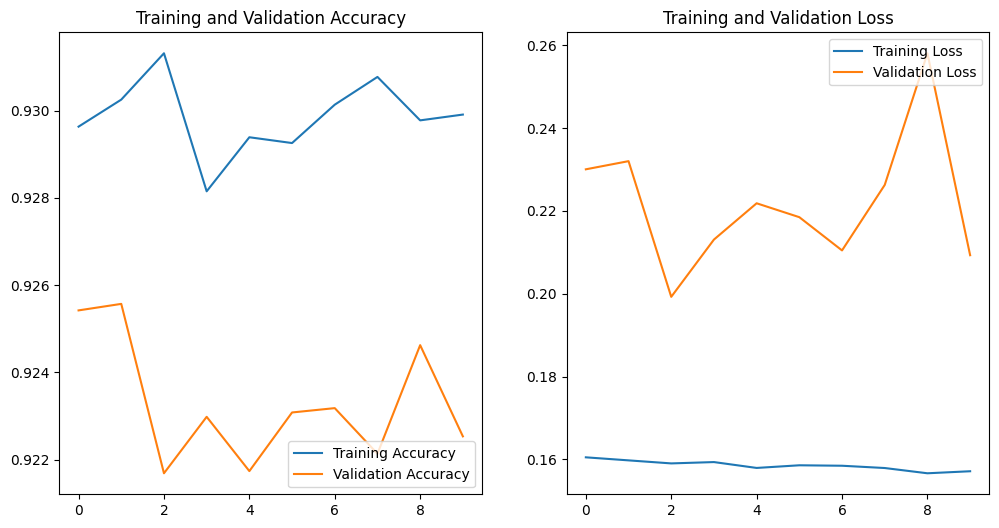

In [23]:
import matplotlib.pyplot as plt

history = model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=10,
    batch_size=32
)

# Plotting the learning curves
def plot_learning_curves(history):
    # Extract loss and accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot accuracy over epochs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot learning curves
plot_learning_curves(history)


## Evaluate test_docs Using the Trained Model

 This involves preprocessing the test documents with the same tokenizer and padding settings used during training, making predictions, and interpreting the results.

**Explanation of Results:**

Prediction Values: Each document receives a prediction value between 0 and 1.  
Interpretation: If the prediction value is greater than 0.5, the document is classified as related to health and wellness; otherwise, it's classified as "Other".

In [24]:
# Test documents
test_docs = [
    'To keep the body in good condition is a duty… otherwise we shall not be able to keep our mind strong and clear.',
    'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
    'You can’t pour from an empty cup. Take care of yourself first.',
    'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
    'The greatest glory in living lies not in never falling, but in rising every time we fall.',
    'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.',
    'In the end, we will remember not the words of our enemies, but the silence of our friends.'
]

# Preprocess the test documents using the trained tokenizer
test_sequences = tokenizer.texts_to_sequences(test_docs)
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

# Make predictions using the trained model
predictions = model.predict(test_padded)

# Print predictions and interpret the results
for i, doc in enumerate(test_docs):
    prediction = predictions[i][0]
    label = 'Health & Wellness Article' if prediction > 0.5 else 'Other'
    print(f"Document: {doc}\nPrediction: {prediction:.4f} ({label})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Document: To keep the body in good condition is a duty… otherwise we shall not be able to keep our mind strong and clear.
Prediction: 0.7935 (Health & Wellness Article)

Document: Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
Prediction: 0.7819 (Health & Wellness Article)

Document: You can’t pour from an empty cup. Take care of yourself first.
Prediction: 0.0681 (Other)

Document: Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
Prediction: 0.1348 (Other)

Document: The greatest glory in living lies not in never falling, but in rising every time we fall.
Prediction: 0.1754 (Other)

Document: A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish communi

In [25]:
# Save the trained model
model.save('health_wellness_classifier.keras')


## Conclusion

The development and evaluation of the text classification model using Keras 3 provided valuable insights into the model’s ability to distinguish health and wellness-related content from other categories. By leveraging Keras's text preprocessing tools and building a transformer-based model, we successfully trained and tested the classifier on pre-split datasets. The learning curves for loss and accuracy demonstrated the model's learning behavior, highlighting the balance between training and validation performance. Continuous monitoring of these curves allowed us to identify signs of overfitting or underfitting and make necessary adjustments.

The model's evaluation on unseen test data showed promising results, accurately identifying health and wellness-related headlines, which supports its potential application in real-world scenarios such as contextual advertising. Future steps could include further fine-tuning, exploring larger or more complex models, and deploying the model into production environments. Overall, the project showcases the effective use of deep learning for text classification, emphasizing the importance of data preprocessing, model evaluation, and ongoing optimization for achieving high-performing machine learning solutions.